<a href="https://colab.research.google.com/github/cdowlatram/Stereoscopic-Image-Analysis/blob/master/Senior_Design_Focal_Length_Model_Transfer_Learning_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is a work in progress and serves as the basis for creating the model which will be used for focal length inferences in our GUI.

# Imports

In [0]:
!pip install pymysql

import gc
import pymysql
import os

In [0]:
# Pandas and Numpy for data structures and util fucntions
import numpy as np
import pandas as pd
from numpy.random import rand

pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn.model_selection import train_test_split

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [0]:
from keras import regularizers
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation,Dense
from keras.models import Sequential,load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import NASNetLarge

Using TensorFlow backend.


In [0]:
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc 


def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
                        

def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    


def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                labels=level_labels)) 
    print(cm_frame) 
    
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)


def plot_model_decision_surface(clf, train_features, train_labels,
                                plot_step=0.02, cmap=plt.cm.RdYlBu,
                                markers=None, alphas=None, colors=None):
    
    if train_features.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = train_features[:, 0].min() - plot_step, train_features[:, 0].max() + plot_step
    y_min, y_max = train_features[:, 1].min() - plot_step, train_features[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf_est = clone(clf)
    clf_est.fit(train_features,train_labels)
    if hasattr(clf_est, 'predict_proba'):
        Z = clf_est.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf_est.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)
    
    le = LabelEncoder()
    y_enc = le.fit_transform(train_labels)
    n_classes = len(le.classes_)
    plot_colors = ''.join(colors) if colors else [None] * n_classes
    label_names = le.classes_
    markers = markers if markers else [None] * n_classes
    alphas = alphas if alphas else [None] * n_classes
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_enc == i)
        plt.scatter(train_features[idx, 0], train_features[idx, 1], c=color,
                    label=label_names[i], cmap=cmap, edgecolors='black', 
                    marker=markers[i], alpha=alphas[i])
    plt.legend()
    plt.show()


def plot_model_roc_curve(clf, features, true_labels, label_encoder=None, class_names=None):
    
    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class_names!')
    n_classes = len(class_labels)
    y_test = label_binarize(true_labels, classes=class_labels)
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prob = clf.predict_proba(features)
            y_score = prob[:, prob.shape[1]-1] 
        elif hasattr(clf, 'decision_function'):
            prob = clf.decision_function(features)
            y_score = prob[:, prob.shape[1]-1]
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
        
        fpr, tpr, _ = roc_curve(y_test, y_score)      
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
                                 ''.format(roc_auc),
                 linewidth=2.5)
        
    elif n_classes > 2:
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(features)
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        ## Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ## Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ## Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]), linewidth=3)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]), linewidth=3)

        for i, label in enumerate(class_labels):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(label, roc_auc[i]), 
                     linewidth=2, linestyle=':')
    else:
        raise ValueError('Number of classes should be atleast 2 or more')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Pulling Training Data

In [0]:
%time
!wget "https://ndownloader.figshare.com/files/5317945"
!wget "https://ndownloader.figshare.com/files/5317948"
!wget "https://ndownloader.figshare.com/files/5317951"
!wget "https://ndownloader.figshare.com/files/5317966"

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
--2019-11-22 19:09:00--  https://ndownloader.figshare.com/files/5317945
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 34.252.88.235, 52.208.39.29, 52.18.118.253, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|34.252.88.235|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/5317945/images.part1.rar [following]
--2019-11-22 19:09:00--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/5317945/images.part1.rar
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.52.194
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.52.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2097152000 (2.0G) [binary/octet-stream]
Saving to: ‘5317945’

5317945             100%[===================>]   1.95G  20.9MB/s    in 96s     

2019-11-22 19:1

In [0]:
%time
!wget "http://landmark.cs.cornell.edu/projects/1dsfm/images.Alamo.tar"
!wget "http://landmark.cs.cornell.edu/projects/1dsfm/images.Ellis_Island.tar"
!wget "http://landmark.cs.cornell.edu/projects/1dsfm/images.Madrid_Metropolis.tar"
!wget "http://landmark.cs.cornell.edu/projects/1dsfm/images.Montreal_Notre_Dame.tar"
!wget "http://landmark.cs.cornell.edu/projects/1dsfm/images.NYC_Library.tar"
!wget "http://landmark.cs.cornell.edu/projects/1dsfm/images.Piazza_del_Popolo.tar"
!wget "http://landmark.cs.cornell.edu/projects/1dsfm/images.Piccadilly.tar"
!wget "http://landmark.cs.cornell.edu/projects/1dsfm/images.Roman_Forum.tar"
!wget "http://landmark.cs.cornell.edu/projects/1dsfm/images.Tower_of_London.tar"
!wget "http://landmark.cs.cornell.edu/projects/1dsfm/images.Trafalgar.tar"
!wget "http://landmark.cs.cornell.edu/projects/1dsfm/images.Union_Square.tar"
!wget "http://landmark.cs.cornell.edu/projects/1dsfm/images.Vienna_Cathedral.tar"
!wget "http://landmark.cs.cornell.edu/projects/1dsfm/images.Yorkminster.tar"
!wget "http://landmark.cs.cornell.edu/projects/1dsfm/images.Gendarmenmarkt.tar"

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 8.82 µs
--2019-11-22 19:14:55--  http://landmark.cs.cornell.edu/projects/1dsfm/images.Alamo.tar
Resolving landmark.cs.cornell.edu (landmark.cs.cornell.edu)... 128.253.51.24
Connecting to landmark.cs.cornell.edu (landmark.cs.cornell.edu)|128.253.51.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2088273408 (1.9G) [application/x-tar]
Saving to: ‘images.Alamo.tar’

images.Alamo.tar    100%[===================>]   1.94G  40.9MB/s    in 51s     

2019-11-22 19:15:46 (39.4 MB/s) - ‘images.Alamo.tar’ saved [2088273408/2088273408]

--2019-11-22 19:15:47--  http://landmark.cs.cornell.edu/projects/1dsfm/images.Ellis_Island.tar
Resolving landmark.cs.cornell.edu (landmark.cs.cornell.edu)... 128.253.51.24
Connecting to landmark.cs.cornell.edu (landmark.cs.cornell.edu)|128.253.51.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1621630976 (1.5G) [application/x-tar]
Saving to: ‘images.Ellis_

# Unzipping Training Data

In [0]:
%time
get_ipython().system_raw("unrar x 5317945")
get_ipython().system_raw("unrar x 5317948")
get_ipython().system_raw("unrar x 5317951")
get_ipython().system_raw("unrar x 5317966")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 7.87 µs


In [0]:
%time
get_ipython().system_raw("tar xvf images.Tower_of_London.tar")
get_ipython().system_raw("tar xvf images.Ellis_Island.tar")
get_ipython().system_raw("tar xvf images.Roman_Forum.tar")
get_ipython().system_raw("tar xvf images.Vienna_Cathedral.tar")
get_ipython().system_raw("tar xvf images.Yorkminster.tar")
get_ipython().system_raw("tar xvf images.Trafalgar.tar")
get_ipython().system_raw("tar xvf images.Piccadilly.tar")
get_ipython().system_raw("tar xvf images.Union_Square.tar")
get_ipython().system_raw("tar xvf images.Montreal_Notre_Dame.tar")
get_ipython().system_raw("tar xvf images.NYC_Library.tar")
get_ipython().system_raw("tar xvf images.Madrid_Metropolis.tar")
get_ipython().system_raw("tar xvf images.Alamo.tar")
get_ipython().system_raw("tar xvf images.Gendarmenmarkt.tar")
get_ipython().system_raw("tar xvf images.Piazza_del_Popolo.tar")

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11.4 µs


# Database Connection

In [0]:
%time
cnx = {'host':'sd2.c9nvxjjovvt6.us-east-1.rds.amazonaws.com','username':'admin','pwd':'bgAHqMhOGFcNOVRmvT7n','db':'Images'}
connection = pymysql.connect(cnx['host'], cnx['username'], cnx['pwd'], cnx['db'])
query = "SELECT Images.image_id, Images.image_left, round(Focal_Lengths.value) FROM Images INNER JOIN Focal_Lengths ON Images.image_id = Focal_Lengths.image_id;"
image_table_1 = pd.read_sql(query, connection)
image_table_1 = image_table_1.rename(columns={'round(Focal_Lengths.value)': 'focal_length'})
query = "SELECT Sensor_Widths.image_id, round(Sensor_Widths.value) FROM Sensor_Widths"
image_table_2 = pd.read_sql(query, connection)
image_table_2 = image_table_2.rename(columns={'round(Sensor_Widths.value)': 'sensor_width'})
query = "SELECT Sensor_Heights.image_id, round(Sensor_Heights.value) FROM Sensor_Heights"
image_table_3 = pd.read_sql(query, connection)
image_table_3 = image_table_3.rename(columns={'round(Sensor_Heights.value)': 'sensor_height'})
image_table = image_table_1.merge(image_table_2, how='inner', on='image_id').reset_index(drop=True)
image_table = image_table.merge(image_table_3, how='inner', on='image_id').reset_index(drop=True)

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 11.2 µs


# Organizing Data

In [0]:
%time
path = (os.getcwd())
images = []
image_path_dict = {}
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
  for file in f:
    if '.jpg' in file:
      images.append(file)
      image_path_dict[file] = r+'/'+file

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 17.4 µs


In [0]:
len(image_path_dict)

290766

In [0]:
%time
image_table_1dsfm = image_table[image_table['image_left'].isin(images)]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.34 µs


In [0]:
len(image_table_1dsfm)

99804

In [0]:
%time
image_table_1dsfm['image_path'] = image_table_1dsfm['image_left'].map(lambda x: image_path_dict[x])

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


In [0]:
def calculate_angle_of_view(row):
  img = load_img(row['image_path'])
  width = img.width
  height = img.height
  focal_length = row['focal_length']
  if width >= height:
    sensor_width = row['sensor_width']
  else:
    sensor_width = row['sensor_height']
  angle_of_view = 2 * np.arctan(sensor_width/(2*focal_length))
  row['angle_of_view'] = round((angle_of_view) * (180/np.pi))
  return row

In [0]:
image_table_1dsfm = image_table_1dsfm.apply(calculate_angle_of_view, axis=1)

In [0]:
image_table_1dsfm['angle_of_view'].value_counts().head(12)

67.0     6398
27.0     3924
7.0      3853
19.0     3840
25.0     3606
53.0     3473
40.0     2941
74.0     2857
38.0     2814
100.0    2755
95.0     2683
90.0     2498
Name: angle_of_view, dtype: int64

In [0]:
angle_count = image_table_1dsfm['angle_of_view'].value_counts().sort_index().to_dict()

In [0]:
threshold = 2750
target_count = {}
for key in angle_count:
  if angle_count[key] >= threshold:
    target_count[key] = angle_count[key]

In [0]:
target_count

{7.0: 3853,
 19.0: 3840,
 25.0: 3606,
 27.0: 3924,
 38.0: 2814,
 40.0: 2941,
 53.0: 3473,
 67.0: 6398,
 74.0: 2857,
 100.0: 2755}

In [0]:
%time
image_table_1dsfm_sample = image_table_1dsfm[image_table_1dsfm['angle_of_view'].isin(target_count.keys())]
# image_table_1dsfm_sample = image_table_1dsfm_sample[image_table_1dsfm_sample['angle_of_view'].isin([float(i) for i in range(19, 90)])]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [0]:
image_table_1dsfm_sample['angle_of_view'].nunique()

10

In [0]:
%time
data_labels = pd.DataFrame()
for focal_length, group in image_table_1dsfm_sample.groupby('angle_of_view'):
  data_labels = data_labels.append(group.sample(800))
data_labels = data_labels.sample(frac=1).reset_index(drop=True)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


In [0]:
target_labels = data_labels['angle_of_view']
len(set(target_labels))

10

In [0]:
labels_ohe_names = pd.get_dummies(target_labels, sparse=True)
labels_ohe = np.asarray(labels_ohe_names)
print(labels_ohe.shape)
print(labels_ohe[:2])

(8000, 10)
[[0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]]


In [0]:
%time
train_data = []
for img in data_labels['image_path'].values.tolist():
  img = load_img(img)
  width = img.width
  height = img.height
  crop = min(width, height)
  img = img_to_array(img)
  img = img[(height//2)-(crop//2):(height//2)+(crop//2), (width//2)-(crop//2):(width//2)+(crop//2)]
  img = array_to_img(img)
  img = img.resize(size=(299, 299))
  img = img_to_array(img)
  train_data.append(img)
train_data = np.array(train_data).astype('float32')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


In [0]:
train_data.shape

(8000, 299, 299, 3)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(train_data, 
                                                    target_labels, 
                                                    test_size=0.3, 
                                                    stratify=np.array(target_labels), 
                                                    random_state=42)

In [0]:
x_train.shape, x_test.shape

((5600, 299, 299, 3), (2400, 299, 299, 3))

In [0]:
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=0.15, 
                                                    stratify=np.array(y_train), 
                                                    random_state=42)

In [0]:
x_train.shape, x_val.shape

((4760, 299, 299, 3), (840, 299, 299, 3))

In [0]:
y_train_ohe = pd.get_dummies(y_train.reset_index(drop=True)).as_matrix()
y_val_ohe = pd.get_dummies(y_val.reset_index(drop=True)).as_matrix()
y_test_ohe = pd.get_dummies(y_test.reset_index(drop=True)).as_matrix()

y_train_ohe.shape, y_test_ohe.shape, y_val_ohe.shape

((4760, 10), (2400, 10), (840, 10))

In [0]:
BATCH_SIZE = 32

In [0]:
# Create train generator.
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(x_train, y_train_ohe, shuffle=False, batch_size=BATCH_SIZE, seed=1)

In [0]:
# Create validation generator
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(x_val, y_val_ohe, shuffle=False, batch_size=BATCH_SIZE, seed=1)

In [0]:
base_inception = InceptionV3(weights='imagenet', include_top = False, input_shape=(299, 299, 3))














87916544/87910968 [==============================] - 6s 0us/step


In [0]:
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
total_classes = y_train_ohe.shape[1]
predictions = Dense(total_classes, activation='softmax')(out)

In [0]:
model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

In [0]:
# Train the model
batch_size = BATCH_SIZE
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=30,
                              verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
111/111 [==============================] - 20s 179ms/step - loss: 2.4917 - acc: 0.0972 - val_loss: 2.4832 - val_acc: 0.1234
Epoch 2/30
111/111 [==============================] - 12s 105ms/step - loss: 2.3814 - acc: 0.1547 - val_loss: 2.4449 - val_acc: 0.1472
Epoch 3/30
111/111 [==============================] - 11s 101ms/step - loss: 2.2971 - acc: 0.2116 - val_loss: 2.4555 - val_acc: 0.1355
Epoch 4/30
111/111 [==============================] - 11s 101ms/step - loss: 2.2048 - acc: 0.2618 - val_loss: 2.5143 - val_acc: 0.1455
Epoch 5/30
111/111 [==============================] - 11s 101ms/step - loss: 2.1120 - acc: 0.2969 - val_loss: 2.4843 - val_acc: 0.1622
Epoch 6/30
111/111 [==============================] - 11s 100ms/step - loss: 2.0250 - acc: 0.3338 - val_loss: 2.4681 - val_acc: 0.1622
Epoch 7/30
111/111 [==============================] - 11s 101ms/step - loss: 1.9272 - acc: 0.3

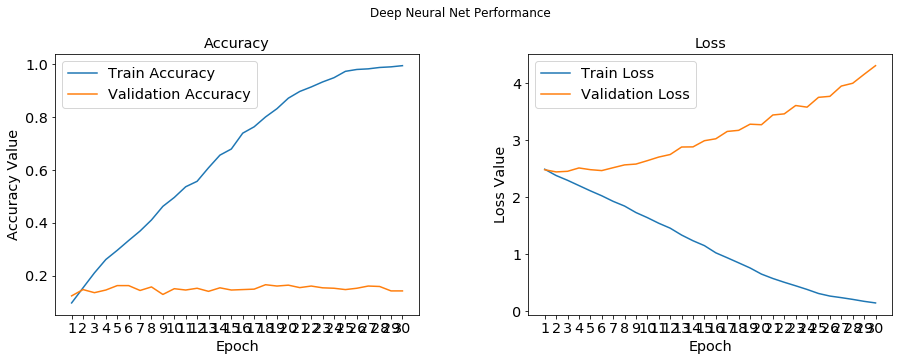

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,31))
ax1.plot(epochs, history.history['acc'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
# scaling test features
x_test /= 255.

In [0]:
test_predictions = model.predict(x_test)
test_predictions

array([[4.6083357e-04, 9.3297672e-04, 1.8648691e-03, ..., 2.1851568e-02,
        1.9793525e-02, 4.7283914e-02],
       [8.0092447e-03, 1.4752965e-01, 3.1444186e-01, ..., 2.0592470e-02,
        4.4129647e-02, 1.2362095e-01],
       [9.6252137e-05, 2.1003010e-03, 3.9500499e-04, ..., 1.1252975e-01,
        1.1612056e-03, 8.1920153e-01],
       ...,
       [2.1041140e-03, 2.9577112e-02, 2.3681788e-02, ..., 5.5206972e-01,
        1.1263129e-03, 4.5336154e-04],
       [8.9861121e-04, 4.0959124e-03, 3.4498246e-04, ..., 1.7716245e-01,
        1.8778682e-01, 9.2172772e-02],
       [3.6896530e-03, 8.1451654e-01, 2.2806707e-03, ..., 1.2846121e-02,
        2.6345986e-03, 3.9018693e-04]], dtype=float32)

In [0]:
predictions = pd.DataFrame(test_predictions, columns=labels_ohe_names.columns)
predictions.head()

,19.0,25.0,27.0,29.0,38.0,40.0,53.0,54.0,57.0,62.0,67.0,74.0
0,0.000461,0.000933,0.001865,0.001020,0.842264,0.000181,0.055491,0.000012,0.008843,0.021852,0.019794,0.047284
1,0.008009,0.147530,0.314442,0.076054,0.077172,0.003659,0.163126,0.001526,0.020139,0.020592,0.044130,0.123621
2,0.000096,0.002100,0.000395,0.004095,0.012346,0.015132,0.032018,0.000497,0.000427,0.112530,0.001161,0.819202
3,0.005396,0.986479,0.000002,0.001021,0.000136,0.000140,0.003149,0.000025,0.000158,0.003301,0.000157,0.000037
4,0.000098,0.066378,0.000006,0.826479,0.000384,0.011799,0.063967,0.000104,0.000770,0.002409,0.010657,0.016949


In [0]:
test_labels = list(y_test)
predictions = list(predictions.idxmax(axis=1))
predictions[:10]

[38.0, 27.0, 74.0, 25.0, 29.0, 29.0, 62.0, 53.0, 29.0, 53.0]

In [0]:
get_metrics(true_labels=test_labels,
            predicted_labels=predictions)

Accuracy: 0.1272
Precision: 0.1304
Recall: 0.1272
F1 Score: 0.122


In [0]:
display_classification_report(true_labels=test_labels,
                              predicted_labels=predictions,
                              classes=list(labels_ohe_names.columns))

              precision    recall  f1-score   support

        19.0       0.17      0.17      0.17       150
        25.0       0.17      0.24      0.20       150
        27.0       0.16      0.05      0.07       150
        29.0       0.08      0.13      0.10       150
        38.0       0.13      0.13      0.13       150
        40.0       0.20      0.11      0.14       150
        53.0       0.09      0.11      0.10       150
        54.0       0.11      0.07      0.08       150
        57.0       0.08      0.05      0.06       150
        62.0       0.13      0.23      0.17       150
        67.0       0.10      0.07      0.09       150
        74.0       0.14      0.15      0.15       150

    accuracy                           0.13      1800
   macro avg       0.13      0.13      0.12      1800
weighted avg       0.13      0.13      0.12      1800



In [0]:
gc.collect()

31

In [0]:
model.save('model_1.h5')

In [0]:
base_xception = Xception(weights='imagenet', include_top = False, input_shape=(299, 299, 3))













83689472/83683744 [==============================] - 2s 0us/step


In [0]:
# Add a global spatial average pooling layer
out = base_xception.output
out = GlobalAveragePooling2D()(out)
out = Dropout(0.1)(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
out = Dropout(0.1)(out)
total_classes = y_train_ohe.shape[1]
predictions = Dense(total_classes, activation='softmax')(out)

In [0]:
model = Model(inputs=base_xception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_xception.layers:
    layer.trainable = False
    
# Compile 
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

In [0]:
# Train the model
batch_size = BATCH_SIZE
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=30,
                              verbose=1)

Epoch 1/30
148/148 [==============================] - 29s 197ms/step - loss: 2.2757 - acc: 0.1415 - val_loss: 2.2309 - val_acc: 0.1755
Epoch 2/30
148/148 [==============================] - 26s 176ms/step - loss: 2.1457 - acc: 0.2232 - val_loss: 2.1609 - val_acc: 0.1918
Epoch 3/30
148/148 [==============================] - 26s 176ms/step - loss: 2.0277 - acc: 0.2796 - val_loss: 2.1551 - val_acc: 0.1968
Epoch 4/30
148/148 [==============================] - 26s 176ms/step - loss: 1.9451 - acc: 0.3071 - val_loss: 2.1691 - val_acc: 0.1819
Epoch 5/30
148/148 [==============================] - 26s 176ms/step - loss: 1.8577 - acc: 0.3480 - val_loss: 2.1439 - val_acc: 0.1955
Epoch 6/30
148/148 [==============================] - 26s 176ms/step - loss: 1.7967 - acc: 0.3738 - val_loss: 2.1543 - val_acc: 0.1906
Epoch 7/30
148/148 [==============================] - 26s 176ms/step - loss: 1.7162 - acc: 0.4076 - val_loss: 2.1981 - val_acc: 0.2017
Epoch 8/30
148/148 [==============================] - 2

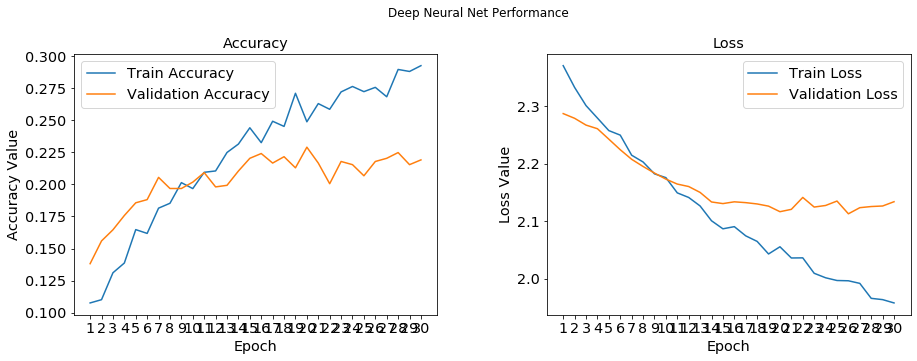

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,31))
ax1.plot(epochs, history.history['acc'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
test_predictions = model.predict(x_test)
test_predictions

array([[4.9610720e-09, 7.4511331e-01, 5.1414605e-05, ..., 2.2802286e-10,
        2.4789180e-01, 2.5113214e-09],
       [2.7929144e-03, 9.9707830e-01, 6.3628286e-06, ..., 1.9853649e-14,
        1.2250872e-08, 4.8215078e-13],
       [1.5579669e-03, 9.9844199e-01, 2.0652015e-16, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [2.1677003e-04, 9.9968493e-01, 5.0589235e-05, ..., 6.4238924e-24,
        1.4879674e-11, 4.1770363e-21],
       [2.5197728e-06, 9.4623607e-01, 4.8478731e-04, ..., 2.0765584e-10,
        4.6166595e-02, 6.2789045e-06],
       [8.5538602e-08, 9.5202429e-03, 1.6189059e-03, ..., 4.9523629e-07,
        8.0763710e-01, 1.7418856e-06]], dtype=float32)

In [0]:
predictions = pd.DataFrame(test_predictions, columns=labels_ohe_names.columns)
predictions.head()

,7.0,19.0,25.0,27.0,38.0,40.0,53.0,67.0,74.0,100.0
0,4.961072e-09,0.745113,5.141460e-05,5.206295e-04,5.820199e-04,5.709136e-03,1.316617e-04,2.280229e-10,2.478918e-01,2.511321e-09
1,2.792914e-03,0.997078,6.362829e-06,2.132005e-07,1.586864e-05,1.064723e-04,1.554427e-11,1.985365e-14,1.225087e-08,4.821508e-13
2,1.557967e-03,0.998442,2.065201e-16,3.951911e-31,3.970989e-20,4.880576e-30,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,3.621096e-01,0.637890,4.373763e-08,1.506935e-27,1.335740e-23,1.154093e-21,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,6.270558e-26,0.999811,2.423870e-14,2.263437e-24,1.884987e-04,1.564649e-13,2.448596e-13,4.098385e-23,5.884420e-12,3.337781e-21


In [0]:
test_labels = list(y_test)
predictions = list(predictions.idxmax(axis=1))
predictions[:10]

[19.0, 19.0, 19.0, 19.0, 19.0, 38.0, 19.0, 19.0, 19.0, 19.0]

In [0]:
get_metrics(true_labels=test_labels,
            predicted_labels=predictions)

Accuracy: 0.1017
Precision: 0.1024
Recall: 0.1017
F1 Score: 0.0553


In [0]:
display_classification_report(true_labels=test_labels,
                              predicted_labels=predictions,
                              classes=list(labels_ohe_names.columns))

              precision    recall  f1-score   support

         7.0       0.16      0.11      0.13       240
        19.0       0.09      0.70      0.16       240
        25.0       0.17      0.03      0.04       240
        27.0       0.00      0.00      0.00       240
        38.0       0.03      0.00      0.01       240
        40.0       0.18      0.05      0.08       240
        53.0       0.00      0.00      0.00       240
        67.0       0.00      0.00      0.00       240
        74.0       0.11      0.12      0.11       240
       100.0       0.29      0.01      0.02       240

    accuracy                           0.10      2400
   macro avg       0.10      0.10      0.06      2400
weighted avg       0.10      0.10      0.06      2400



In [0]:
gc.collect()

18

In [0]:
model.save('aov_model.h5')